# PSYCH 239: Final Project: Representation of Category Variance in NN


In [0]:
import requests 
import io
import copy
import torch
import tqdm
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms, models, utils
from pylab import *
from PIL import Image
from torchvision.utils import make_grid
from torch.autograd import Variable
import numpy as np
import operator
import pandas as pd
import pickle 
from itertools import combinations 
import seaborn as sns
from scipy.stats import spearmanr

In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
data_transform = transforms.Compose([
        transforms.RandomSizedCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

/usr/local/lib/python3.6/dist-packages/torchvision/transforms/transforms.py:704: UserWarning: The use of the transforms.RandomSizedCrop transform is deprecated, please use transforms.RandomResizedCrop instead.
  "please use transforms.RandomResizedCrop instead.")


In [0]:
from torch.utils.data import Dataset
class MyTrainingDataset(Dataset):
    def __init__(self, root, class_num, transform=None, target_transform=None):
        self.root = root
        self.class_num = class_num
        self.transform = transform
        self.target_transform = target_transform
        

    def __len__(self):
        return len(self.root)

    def __getitem__(self, idx):
      try:
        #write here code to obtain one data sample and target
          sample = Image.open(io.BytesIO(requests.get(self.root[idx]).content))
        
          #sample = self.img_norm(sample)
          target = self.class_num

          if self.transform:
            sample = self.transform(sample)
          if self.target_transform:
            target = self.target_transform(target)
          return sample, target
      except:
        return self.__getitem__(idx+1)

          


In [0]:
# Update as you need
 def is_broken(link):
     try:
         response = requests.get(link)
         if response.status_code != 200:
             return True
         return False
     except Exception as e:
         return True

In [0]:
def filter_imgs(img_urls):
  # filter out list so get 200 useable images
  filterd_urls = []
  i=0
  while len(filterd_urls) < 200:
    if not is_broken(img_urls[i]):
      filterd_urls.append(img_urls[i])
    i += 1
  
  return filterd_urls


def make_dataset(wordnet_id,class_num):
  url_prefix = "http://www.image-net.org/api/text/imagenet.synset.geturls?wnid="
  urls = url_prefix + wordnet_id
  response = requests.get(urls)
  imgs_url_bytes = io.BytesIO(response.content)
  img_urls = str(response.content[2:]).split('\\r\\n')
  filtered_img_urls = filter_imgs(img_urls)
      
  dataset = MyTrainingDataset(filtered_img_urls,class_num,transform=data_transform)
  print('done')
  return dataset

In [0]:
birds = make_dataset("n01503061",0)
clothing = make_dataset("n03051540",1)
fish = make_dataset("n02512053",2)
fruit = make_dataset("n13134947",3)
insects = make_dataset("n02159955",4)
utensils = make_dataset("n04516672",5)
mammal = make_dataset("n01861778",6)

train_dataset = torch.utils.data.ConcatDataset([birds,clothing,fish,fruit,insects,utensils,mammal])
import pickle

with open('./drive/My Drive/train_dataset.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump([train_dataset], f)

In [0]:
file = open('./drive/My Drive/train_dataset.pkl','rb')
data= pickle.load(file)
train_dataset = data[0]
file.close()

In [0]:
# Create training and validation dataloaders
def create_trainloader():
  train_loader = torch.utils.data.DataLoader(
             train_dataset,
             batch_size=32, shuffle=True)
  return train_loader

In [0]:
train_loader = create_trainloader()

# Finetuning Model 

In [0]:
def train_step(x, t, net, opt_fn, loss_fn):
    y = net(x)
    loss = loss_fn(y, t)
    loss.backward()
    opt_fn.step()
    opt_fn.zero_grad()
    return loss

def fine_tune(model_name, num_classes):
  if model_name == "res_net18":
    net = models.resnet18(pretrained=True)
    num_ftrs = net.fc.in_features
    net.fc = nn.Linear(num_ftrs, num_classes)
  elif model_name == "google_net":
    net = models.googlenet(pretrained=True)
    net.classifier  = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),)
  elif model_name == "alex_net":
    net = models.alexnet(pretrained=True)
    net.classifier  = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),)

  mse_loss = torch.nn.CrossEntropyLoss()
  opt = torch.optim.Adam(net.parameters(), lr=1e-3)

  acc_hist_train = []
  acc_hist_test = []
  for epoch in range(5):
    acc_batch = []
    net.train()
    print(epoch)
    for x,t in tqdm.tqdm(iter(train_loader)):
      loss_ = train_step(x,t,net, opt, mse_loss)
      y = net(x)
      acc_batch.append(torch.mean((t == y.argmax(1)).float()))

    acc_hist_train.append(torch.mean(torch.FloatTensor(acc_batch)))   
    print(loss_)

  # save results 
  with open('./drive/My Drive/fine_tune_'+model_name+'.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump([net], f)
  
  return net 

In [10]:
res_net = fine_tune("res_net",7)
google_net = fine_tune("google_net", 7)
alex_net = fine_tune("alex_net",7)

UnboundLocalError: ignored

In [0]:
# Load models from previous fine-tuning 
file = open('./drive/My Drive/fine_tune_resnet.pkl','rb')
data= pickle.load(file)
res_net = data[0]
file.close()

file = open('./drive/My Drive/fine_tune_google_net.pkl','rb')
data= pickle.load(file)
google_net = data[0]
file.close()

file = open('./drive/My Drive/fine_tune_alex_net.pkl','rb')
data= pickle.load(file)
alex_net = data[0]
file.close()


# Creating the exemplar dataset

In [0]:
# https://gist.github.com/andrewjong/6b02ff237533b3b2c554701fb53d5c4d
class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method that dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [0]:
def load_images(image_folder,image_size=244, batch_size=1,root="./drive/My Drive/category_data/"):
  transform = transforms.Compose([
   transforms.Resize(230),
   transforms.CenterCrop(224),
   transforms.ToTensor(),
   transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

  data_set = ImageFolderWithPaths(root=root+image_folder, transform=transform)
  data_loader = torch.utils.data.DataLoader(data_set, batch_size=batch_size, shuffle=True, num_workers=2)

  return data_loader

In [0]:
bird_loader = load_images("Birds")
fruit_loader = load_images("Fruit")
mammals_loader = load_images("Mammals")
fish_loader = load_images("Fish")
clothing_loader = load_images("Clothing")
insect_loader = load_images("Insects")
kitchen_ut_loader = load_images("KitchenUtensils")

# Calculating typicality and similarity 

In [0]:
def average_over_subclass(output,class_nums):
    # average the proporties from all the subclasses within the superclass 
    all_subclass_outputs = [output[i] for i in class_nums]
    super_class_output = sum(all_subclass_outputs)/len(all_subclass_outputs)
    super_class_output = super_class_output.item()
    return super_class_output

def im_to_vec(net,net_name,im_tensor):
  if net_name == "res_net":
    layer = -1
  else:
    layer = -3
  extractor = nn.Sequential(*list(net.children())[:layer])
  vec = extractor(im_tensor)
  return vec

def within_class_typicality_ratings(net,net_name,data_loader,class_num):
  net.eval()
  rating_name_pairs = []
  feature_embeddings = {}
  for x,t,p in iter(data_loader): 
      sm = torch.nn.Softmax()
      y=sm(net(x))
      rating = y[0][class_num].item()
      name = p[0].split('/')[-1].split('.')[0]
      rating_name_pairs.append((name,rating))
      feature_embeddings[name] = im_to_vec(net,net_name,x)

  return rating_name_pairs,feature_embeddings

def get_human_typicality_ratings(data_frame):
  rating_name_pairs = []
  temp_df = pd.DataFrame({'exemplar': data_frame['exemplar'], 'mean_rating': data_frame['mean']})
  for index,row in temp_df.iterrows():
    rating_name_pairs.append((row['exemplar'],row['mean_rating']))
  return rating_name_pairs

def get_all_typicality_ratings(net,net_name, data_loader, class_num, category_name):
  #layer = net._modules.get('avgpool') # create a reference to the layer we want to extract from, this is a later layer 
  # neural net typicality ratings
  nn_rating_name_pairs,feature_embeddings = within_class_typicality_ratings(net,net_name, data_loader,class_num)
  nn_rating_name_pairs.sort(key = operator.itemgetter(0)) # first sort by name so we can later combine with neural net ratings
  # human ratings
  df = pd.read_excel("/content/drive/My Drive/exemplar judgments/exemplarTypicalityRatings.xls",sheet_name=category_name)
  h_rating_name_pairs = get_human_typicality_ratings(df)
  h_rating_name_pairs = h_rating_name_pairs[:-1]
  h_rating_name_pairs.sort(key = operator.itemgetter(0)) # sort

  # combine human and nn ratings 
  all_rating_name_pairs = []
  for i in range(len(h_rating_name_pairs)):
    name = h_rating_name_pairs[i][0]
    h_rat = h_rating_name_pairs[i][1]
    n_rat = nn_rating_name_pairs[i][1]
    all_rating_name_pairs.append((name,h_rat,n_rat))

  all_rating_name_pairs.sort(key = operator.itemgetter(1))
  all_rating_name_pairs = pd.DataFrame(all_rating_name_pairs, columns=[category_name,'human','nn']) 
  return all_rating_name_pairs, feature_embeddings 

In [0]:
def get_all_pairs(all_rating_name_pairs, category_name):
  all_exemplar_names = all_rating_name_pairs[category_name]
  all_exemplar_names = all_exemplar_names.sort_values()
  all_pairs = list(combinations(all_exemplar_names,2))
  filtered_combinations = filter(lambda x: x[0] != x[1],all_pairs)

  return filtered_combinations

def get_cosine_similarity(ratings, category_name, feature_embeddings):
  all_pairs = get_all_pairs(ratings, category_name)

  all_cosin_sim = pd.DataFrame(columns=["pair","cosine_sim"])
  for p in all_pairs:
    item_1 = p[0]
    item_2 = p[1]

    an_1_vec = feature_embeddings[item_1]
    an_2_vec = feature_embeddings[item_2]

    cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
    cos_sim = cos(an_1_vec,
              an_2_vec).detach().numpy()
    cos_sim = cos_sim[0][0]
    temp_df = pd.DataFrame({'pair':[item_1+"_"+item_2],'cosine_sim':cos_sim})

    all_cosin_sim = all_cosin_sim.append(temp_df)
  return all_cosin_sim

def both_similarity(net_rating,category_name,net_feature_embedding):
  cosin_sim_nn=get_cosine_similarity(net_rating,category_name,net_feature_embedding)
  cosin_sim_nn = cosin_sim_nn.sort_values(by=["pair"])
  cosin_sim_nn = cosin_sim_nn.reset_index()
  cosin_sim_nn = cosin_sim_nn.drop('index',axis=1)


  human_sim = pd.read_csv("./drive/My Drive/avg_pairwise.csv")
  category_sim = human_sim.loc[human_sim["category"]==category_name]
  category_sim = category_sim.drop("category",axis=1)
  category_sim = category_sim.sort_values(by=["pair"])
  category_sim = category_sim.reset_index()
  category_sim = category_sim.drop('index',axis=1)
  
  sim_all = pd.DataFrame({'pair':category_sim['pair'],'human':category_sim['sim'],'nn':cosin_sim_nn['cosine_sim']})
  return sim_all

# Bird category

In [0]:
# Plotting parameters
pal = sns.color_palette("husl",7)
plt.rcParams.update({'font.size': 22})

In [34]:
model_name = "alex_net"
alex_rating, alex_feature_embedding = get_all_typicality_ratings(alex_net, model_name,bird_loader, 0, "Birds")

model_name = "google_net"
google_rating, google_feature_embedding = get_all_typicality_ratings(google_net, model_name,bird_loader, 0, "Birds")

model_name = "res_net"
res_rating, res_feature_embedding = get_all_typicality_ratings(res_net, model_name,bird_loader, 0, "Birds")


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


SpearmanrResult(correlation=nan, pvalue=nan)
SpearmanrResult(correlation=0.3099688550260274, pvalue=0.09551964516238001)
SpearmanrResult(correlation=0.33110815238961144, pvalue=0.07389001898472163)


/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


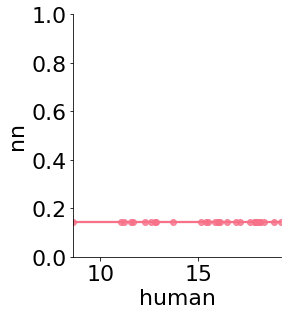

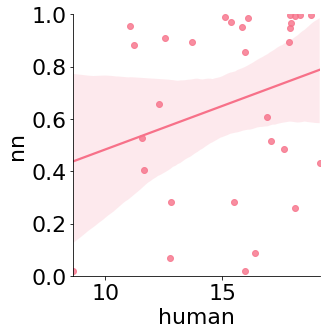

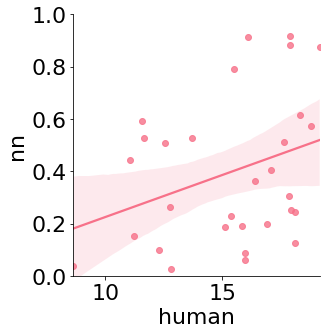

In [21]:

sns.lmplot(x='human',y='nn',data=alex_rating,line_kws={'color': pal[0]},scatter_kws={'color': pal[0]})
plt.ylim([0,1])
plt.savefig("./drive/My Drive/category_data/"+"birds_alex"+"_corr.png",dpi=300)

sns.lmplot(x='human',y='nn',data=google_rating,line_kws={'color': pal[0]},scatter_kws={'color': pal[0]})
plt.ylim([0,1])
plt.savefig("./drive/My Drive/category_data/"+"birds_google"+"_corr.png",dpi=300)

sns.lmplot(x='human',y='nn',data=res_rating,line_kws={'color': pal[0]},scatter_kws={'color': pal[0]})
plt.ylim([0,1])
plt.savefig("./drive/My Drive/category_data/"+"birds_res"+"_corr.png",dpi=300)

print(spearmanr(alex_rating['human'],alex_rating['nn']))
print(spearmanr(google_rating['human'],google_rating['nn']))
print(spearmanr(res_rating['human'],res_rating['nn']))


SpearmanrResult(correlation=0.03656609903928964, pvalue=0.5239680132951227)
SpearmanrResult(correlation=0.031851358325036085, pvalue=0.578872944789861)


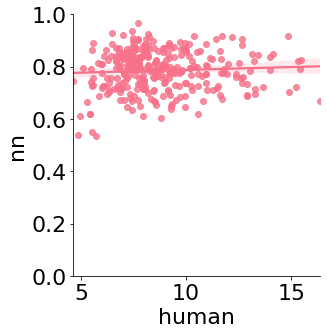

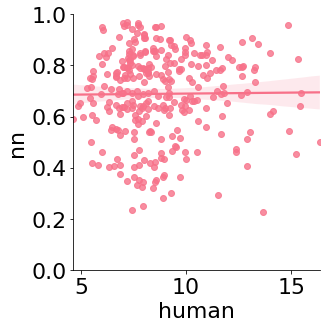

In [37]:
google_sim = both_similarity(google_rating,"Birds",google_feature_embedding)
google_sim = google_sim.replace(0,nan)
res_sim = both_similarity(res_rating,"Birds",res_feature_embedding)
res_sim = res_sim.replace(0,nan)

sns.lmplot(x='human',y='nn',data=google_sim,line_kws={'color': pal[0]},scatter_kws={'color': pal[0]})
plt.ylim([0,1])
plt.savefig("./drive/My Drive/category_data/"+"birds_google"+"_sim.png",dpi=300)

sns.lmplot(x='human',y='nn',data=res_sim,line_kws={'color': pal[0]},scatter_kws={'color': pal[0]})
plt.ylim([0,1])
plt.savefig("./drive/My Drive/category_data/"+"birds_res"+"_sim.png",dpi=300)

print(spearmanr(google_sim['human'],google_sim['nn'],nan_policy='omit'))
print(spearmanr(res_sim['human'],res_sim['nn'],nan_policy='omit'))

# Clothing Category

In [38]:
model_name = "google_net"
google_rating, google_feature_embedding = get_all_typicality_ratings(google_net, model_name,clothing_loader , 1, "Clothing")

model_name = "res_net"
res_rating, res_feature_embedding = get_all_typicality_ratings(res_net, model_name,clothing_loader , 1, "Clothing")


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


SpearmanrResult(correlation=0.08213553054029271, pvalue=0.6777697789544221)
SpearmanrResult(correlation=0.5984942325369328, pvalue=0.0007672390488395876)


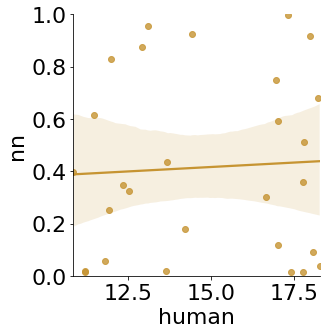

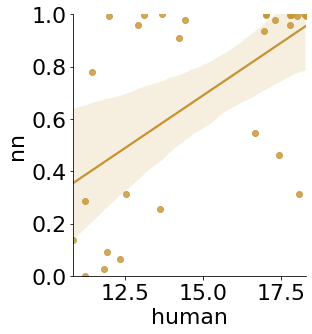

In [28]:
sns.lmplot(x='human',y='nn',data=google_rating,line_kws={'color': pal[1]},scatter_kws={'color': pal[1]})
plt.ylim([0,1])
plt.savefig("./drive/My Drive/category_data/"+"clothing_google"+"_corr.png",dpi=300)

sns.lmplot(x='human',y='nn',data=res_rating,line_kws={'color': pal[1]},scatter_kws={'color': pal[1]})
plt.ylim([0,1])
plt.savefig("./drive/My Drive/category_data/"+"clothing_res"+"_corr.png",dpi=300)


print(spearmanr(google_rating['human'],google_rating['nn']))
print(spearmanr(res_rating['human'],res_rating['nn']))

SpearmanrResult(correlation=0.056011808212238, pvalue=0.3469594698560339)
SpearmanrResult(correlation=0.06481493990293087, pvalue=0.276326572665981)


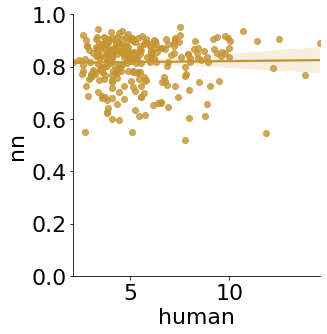

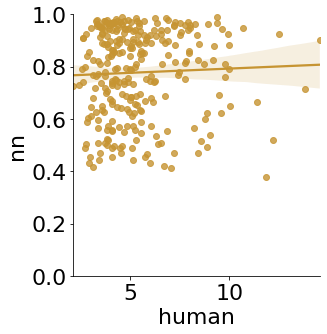

In [39]:
#alex_sim = both_similarity(alex_rating,"Birds",alex_feature_embedding)
google_sim = both_similarity(google_rating,"Clothing",google_feature_embedding)
google_sim = google_sim.replace(0,nan)
res_sim = both_similarity(res_rating,"Clothing",res_feature_embedding)
res_sim = res_sim.replace(0,nan)


#sns.lmplot(x='human',y='nn',data=alex_sim,line_kws={'color': pal[0]},scatter_kws={'color': pal[0]})
#plt.savefig("./drive/My Drive/category_data/"+"birds_alex"+"_sim.png")

sns.lmplot(x='human',y='nn',data=google_sim,line_kws={'color': pal[1]},scatter_kws={'color': pal[1]})
plt.ylim([0,1])
plt.savefig("./drive/My Drive/category_data/"+"clothing_google"+"_sim.png",dpi=300)

sns.lmplot(x='human',y='nn',data=res_sim,line_kws={'color': pal[1]},scatter_kws={'color': pal[1]})
plt.ylim([0,1])
plt.savefig("./drive/My Drive/category_data/"+"clothing_res"+"_sim.png",dpi=300)

print(spearmanr(google_sim['human'],google_sim['nn'],nan_policy='omit'))
print(spearmanr(res_sim['human'],res_sim['nn'],nan_policy='omit'))

# Fish


In [40]:
model_name = "google_net"
google_rating, google_feature_embedding = get_all_typicality_ratings(google_net, model_name,fish_loader, 2, "Fish")

model_name = "res_net"
res_rating, res_feature_embedding = get_all_typicality_ratings(res_net, model_name,fish_loader, 2, "Fish")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


SpearmanrResult(correlation=0.06493506493506496, pvalue=0.7740381664661451)
SpearmanrResult(correlation=-0.07622811970638058, pvalue=0.7359946162262683)


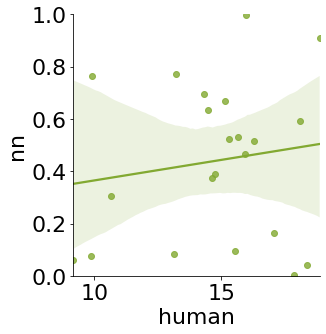

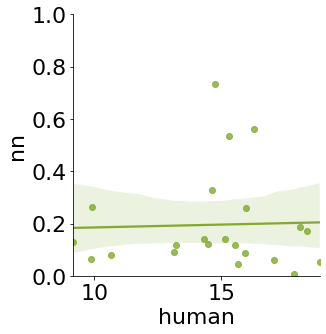

In [38]:
sns.lmplot(x='human',y='nn',data=google_rating,line_kws={'color': pal[2]},scatter_kws={'color': pal[2]})
plt.ylim([0,1])
plt.savefig("./drive/My Drive/category_data/"+"fish_google"+"_corr.png",dpi=300)

sns.lmplot(x='human',y='nn',data=res_rating,line_kws={'color': pal[2]},scatter_kws={'color': pal[2]})
plt.ylim([0,1])
plt.savefig("./drive/My Drive/category_data/"+"fish_res"+"_corr.png",dpi=300)

print(spearmanr(google_rating['human'],google_rating['nn']))
print(spearmanr(res_rating['human'],res_rating['nn']))


SpearmanrResult(correlation=0.07328263693225764, pvalue=0.3188875701813836)
SpearmanrResult(correlation=0.10013935506563255, pvalue=0.17268299639108867)


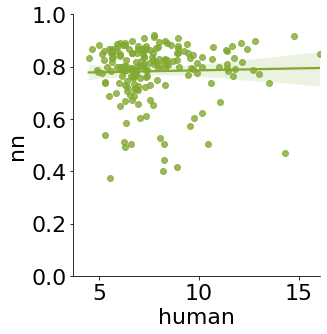

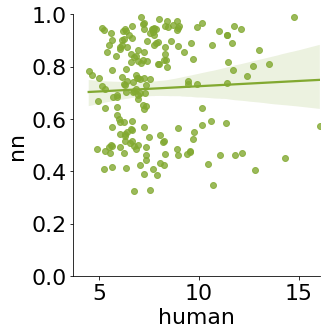

In [41]:
#alex_sim = both_similarity(alex_rating,"Birds",alex_feature_embedding)
google_sim = both_similarity(google_rating,"Fish",google_feature_embedding)
google_sim = google_sim.replace(0,nan)
res_sim = both_similarity(res_rating,"Fish",res_feature_embedding)
res_sim = res_sim.replace(0,nan)

#sns.lmplot(x='human',y='nn',data=alex_sim,line_kws={'color': pal[0]},scatter_kws={'color': pal[0]})
#plt.savefig("./drive/My Drive/category_data/"+"birds_alex"+"_sim.png")

sns.lmplot(x='human',y='nn',data=google_sim,line_kws={'color': pal[2]},scatter_kws={'color': pal[2]})
plt.ylim([0,1])
plt.savefig("./drive/My Drive/category_data/"+"fish_google"+"_sim.png",dpi=300)

sns.lmplot(x='human',y='nn',data=res_sim,line_kws={'color': pal[2]},scatter_kws={'color': pal[2]})
plt.ylim([0,1])
plt.savefig("./drive/My Drive/category_data/"+"fish_res"+"_sim.png",dpi=300)

print(spearmanr(google_sim['human'],google_sim['nn'],nan_policy='omit'))
print(spearmanr(res_sim['human'],res_sim['nn'],nan_policy='omit'))

# Fruit




In [43]:
model_name = "google_net"
google_rating, google_feature_embedding = get_all_typicality_ratings(google_net, model_name,fruit_loader, 3, "Fruit")

model_name = "res_net"
res_rating, res_feature_embedding = get_all_typicality_ratings(res_net, model_name,fruit_loader, 3, "Fruit")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


SpearmanrResult(correlation=0.13499199511187815, pvalue=0.48506247199548813)
SpearmanrResult(correlation=0.09434659512381265, pvalue=0.6263918760554092)


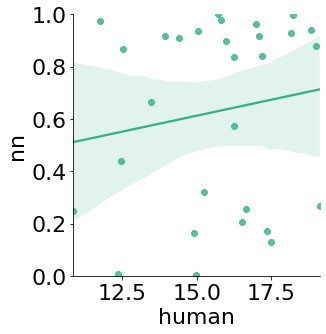

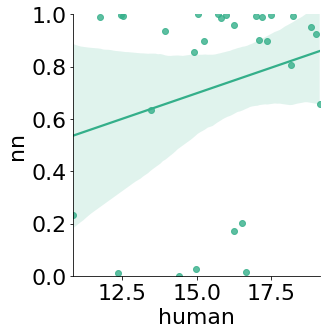

In [41]:
sns.lmplot(x='human',y='nn',data=google_rating,line_kws={'color': pal[3]},scatter_kws={'color': pal[3]})
plt.ylim([0,1])
plt.savefig("./drive/My Drive/category_data/"+"fruit_google"+"_corr.png",dpi=300)

sns.lmplot(x='human',y='nn',data=res_rating,line_kws={'color': pal[3]},scatter_kws={'color': pal[3]})
plt.ylim([0,1])
plt.savefig("./drive/My Drive/category_data/"+"fruit_res"+"_corr.png",dpi=300)

print(spearmanr(google_rating['human'],google_rating['nn']))
print(spearmanr(res_rating['human'],res_rating['nn']))


SpearmanrResult(correlation=-0.08463635264567519, pvalue=0.12725491400108904)
SpearmanrResult(correlation=0.003890806975918943, pvalue=0.9442089634919031)


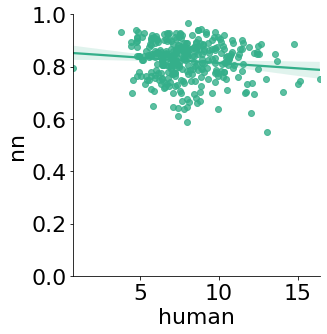

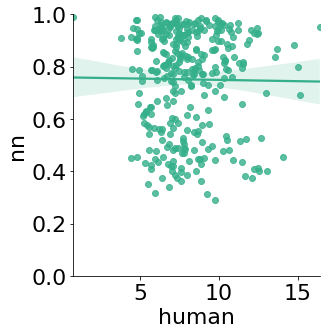

In [44]:
#alex_sim = both_similarity(alex_rating,"Birds",alex_feature_embedding)
google_sim = both_similarity(google_rating,"Fruit",google_feature_embedding)
google_sim = google_sim.replace(0,nan)
res_sim = both_similarity(res_rating,"Fruit",res_feature_embedding)
res_sim = res_sim.replace(0,nan)

#sns.lmplot(x='human',y='nn',data=alex_sim,line_kws={'color': pal[0]},scatter_kws={'color': pal[0]})
#plt.savefig("./drive/My Drive/category_data/"+"birds_alex"+"_sim.png")

sns.lmplot(x='human',y='nn',data=google_sim,line_kws={'color': pal[3]},scatter_kws={'color': pal[3]})
plt.ylim([0,1])
plt.savefig("./drive/My Drive/category_data/"+"fruit_google"+"_sim.png",dpi=300)

sns.lmplot(x='human',y='nn',data=res_sim,line_kws={'color': pal[3]},scatter_kws={'color': pal[3]})
plt.ylim([0,1])
plt.savefig("./drive/My Drive/category_data/"+"fruit_res"+"_sim.png",dpi=300)

print(spearmanr(google_sim['human'],google_sim['nn'],nan_policy='omit'))
print(spearmanr(res_sim['human'],res_sim['nn'],nan_policy='omit'))

# Insects

In [45]:
model_name = "google_net"
google_rating, google_feature_embedding = get_all_typicality_ratings(google_net, model_name,insect_loader, 4, "Insects")

model_name = "res_net"
res_rating, res_feature_embedding = get_all_typicality_ratings(res_net, model_name,insect_loader, 4, "Insects")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


SpearmanrResult(correlation=0.19619157893214148, pvalue=0.347261059254521)
SpearmanrResult(correlation=0.10848240246836058, pvalue=0.6057355559072627)


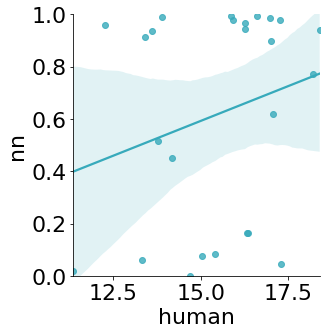

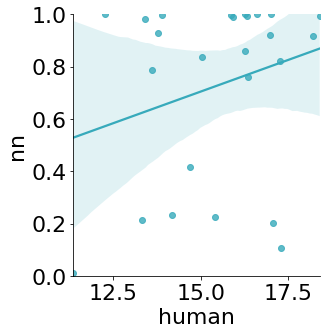

In [44]:
sns.lmplot(x='human',y='nn',data=google_rating,line_kws={'color': pal[4]},scatter_kws={'color': pal[4]})
plt.ylim([0,1])
plt.savefig("./drive/My Drive/category_data/"+"insects_google"+"_corr.png",dpi=300)

sns.lmplot(x='human',y='nn',data=res_rating,line_kws={'color': pal[4]},scatter_kws={'color': pal[4]})
plt.ylim([0,1])
plt.savefig("./drive/My Drive/category_data/"+"insects_res"+"_corr.png",dpi=300)

print(spearmanr(google_rating['human'],google_rating['nn']))
print(spearmanr(res_rating['human'],res_rating['nn']))

SpearmanrResult(correlation=-0.025774888233307577, pvalue=0.6999433408236728)
SpearmanrResult(correlation=0.08195552540023746, pvalue=0.21971156395739547)


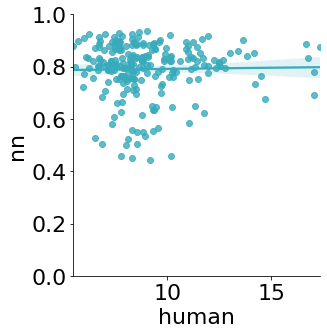

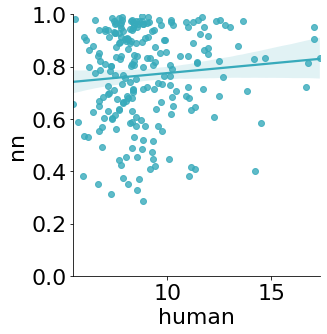

In [46]:
#alex_sim = both_similarity(alex_rating,"Birds",alex_feature_embedding)
google_sim = both_similarity(google_rating,"Insects",google_feature_embedding)
google_sim = google_sim.replace(0,nan)
res_sim = both_similarity(res_rating,"Insects",res_feature_embedding)
res_sim = res_sim.replace(0,nan)

#sns.lmplot(x='human',y='nn',data=alex_sim,line_kws={'color': pal[0]},scatter_kws={'color': pal[0]})
#plt.savefig("./drive/My Drive/category_data/"+"birds_alex"+"_sim.png")

sns.lmplot(x='human',y='nn',data=google_sim,line_kws={'color': pal[4]},scatter_kws={'color': pal[4]})
plt.ylim([0,1])
plt.savefig("./drive/My Drive/category_data/"+"insects_google"+"_sim.png",dpi=300)

sns.lmplot(x='human',y='nn',data=res_sim,line_kws={'color': pal[4]},scatter_kws={'color': pal[4]})
plt.ylim([0,1])
plt.savefig("./drive/My Drive/category_data/"+"insects_res"+"_sim.png",dpi=300)

print(spearmanr(google_sim['human'],google_sim['nn'],nan_policy='omit'))
print(spearmanr(res_sim['human'],res_sim['nn'],nan_policy='omit'))

# Utensils



In [47]:
model_name = "google_net"
google_rating, google_feature_embedding = get_all_typicality_ratings(google_net, model_name,kitchen_ut_loader, 5, "KitchenUtensils")

model_name = "res_net"
res_rating, res_feature_embedding = get_all_typicality_ratings(res_net, model_name,kitchen_ut_loader, 5, "KitchenUtensils")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


SpearmanrResult(correlation=0.12931037963019001, pvalue=0.48058809064072294)
SpearmanrResult(correlation=-0.18928838550121432, pvalue=0.2994597411744885)


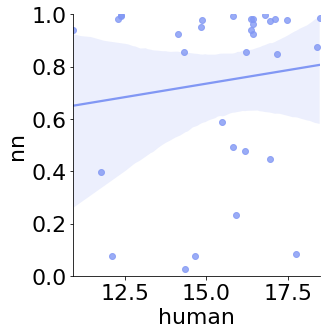

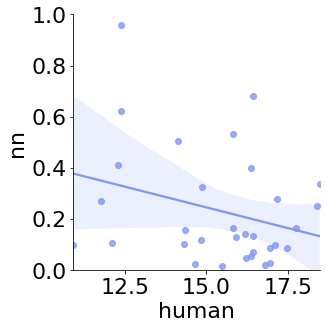

In [47]:
sns.lmplot(x='human',y='nn',data=google_rating,line_kws={'color': pal[5]},scatter_kws={'color': pal[5]})
plt.ylim([0,1])
plt.savefig("./drive/My Drive/category_data/"+"utensils_google"+"_corr.png",dpi=300)


sns.lmplot(x='human',y='nn',data=res_rating,line_kws={'color': pal[5]},scatter_kws={'color': pal[5]})
plt.ylim([0,1])
plt.savefig("./drive/My Drive/category_data/"+"utensils_res"+"_corr.png",dpi=300)

print(spearmanr(google_rating['human'],google_rating['nn']))
print(spearmanr(res_rating['human'],res_rating['nn']))

SpearmanrResult(correlation=0.11374314835391985, pvalue=0.02935791167166927)
SpearmanrResult(correlation=0.08316636096795961, pvalue=0.11170869549955344)


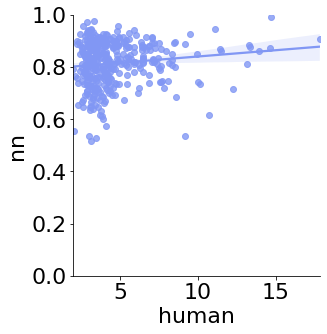

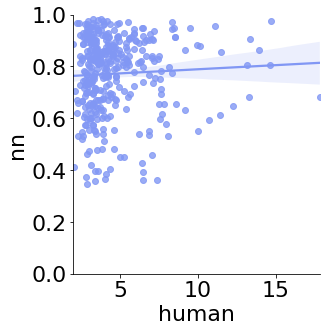

In [48]:
#alex_sim = both_similarity(alex_rating,"Birds",alex_feature_embedding)
google_sim = both_similarity(google_rating,"KitchenUtensils",google_feature_embedding)
google_sim = google_sim.replace(0,nan)
res_sim = both_similarity(res_rating,"KitchenUtensils",res_feature_embedding)
res_sim = res_sim.replace(0,nan)

#sns.lmplot(x='human',y='nn',data=alex_sim,line_kws={'color': pal[0]},scatter_kws={'color': pal[0]})
#plt.savefig("./drive/My Drive/category_data/"+"birds_alex"+"_sim.png")

sns.lmplot(x='human',y='nn',data=google_sim,line_kws={'color': pal[5]},scatter_kws={'color': pal[5]})
plt.ylim([0,1])
plt.savefig("./drive/My Drive/category_data/"+"utensils_google"+"_sim.png",dpi=300)

sns.lmplot(x='human',y='nn',data=res_sim,line_kws={'color': pal[5]},scatter_kws={'color': pal[5]})
plt.ylim([0,1])
plt.savefig("./drive/My Drive/category_data/"+"utensils_res"+"_sim.png",dpi=300)

print(spearmanr(google_sim['human'],google_sim['nn'],nan_policy='omit'))
print(spearmanr(res_sim['human'],res_sim['nn'],nan_policy='omit'))

#Mammals

In [49]:
model_name = "google_net"
google_rating, google_feature_embedding = get_all_typicality_ratings(google_net, model_name,mammals_loader, 6, "Mammals")

model_name = "res_net"
res_rating, res_feature_embedding = get_all_typicality_ratings(res_net, model_name,mammals_loader, 6, "Mammals")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


SpearmanrResult(correlation=0.3199803976693314, pvalue=0.09061357396221943)
SpearmanrResult(correlation=0.13435232413696888, pvalue=0.4871527141362676)


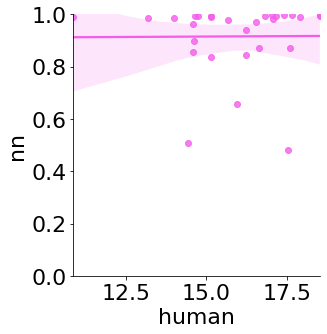

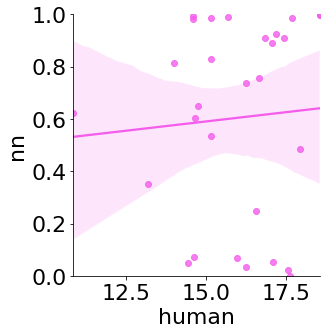

In [50]:
sns.lmplot(x='human',y='nn',data=google_rating,line_kws={'color': pal[6]},scatter_kws={'color': pal[6]})
plt.ylim([0,1])
plt.savefig("./drive/My Drive/category_data/"+"mammals_google"+"_corr.png",dpi=300)


sns.lmplot(x='human',y='nn',data=res_rating,line_kws={'color': pal[6]},scatter_kws={'color': pal[6]})
plt.ylim([0,1])
plt.savefig("./drive/My Drive/category_data/"+"mammals_res"+"_corr.png",dpi=300)

print(spearmanr(google_rating['human'],google_rating['nn']))
print(spearmanr(res_rating['human'],res_rating['nn']))

SpearmanrResult(correlation=-0.030365010611495193, pvalue=0.5895572218961238)
SpearmanrResult(correlation=0.04164659936528854, pvalue=0.45926248362539135)


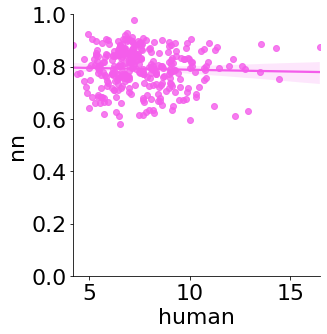

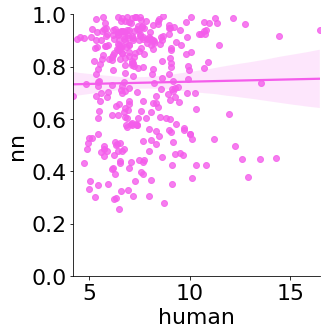

In [51]:
#alex_sim = both_similarity(alex_rating,"Birds",alex_feature_embedding)
google_sim = both_similarity(google_rating,"Mammals",google_feature_embedding)
google_sim = google_sim.replace(0,nan)
res_sim = both_similarity(res_rating,"Mammals",res_feature_embedding)
res_sim = res_sim.replace(0,nan)

#sns.lmplot(x='human',y='nn',data=alex_sim,line_kws={'color': pal[0]},scatter_kws={'color': pal[0]})
#plt.savefig("./drive/My Drive/category_data/"+"birds_alex"+"_sim.png")

sns.lmplot(x='human',y='nn',data=google_sim,line_kws={'color': pal[6]},scatter_kws={'color': pal[6]})
plt.ylim([0,1])
plt.savefig("./drive/My Drive/category_data/"+"mammals_google"+"_sim.png",dpi=300)

sns.lmplot(x='human',y='nn',data=res_sim,line_kws={'color': pal[6]},scatter_kws={'color': pal[6]})
plt.ylim([0,1])
plt.savefig("./drive/My Drive/category_data/"+"mammals_res"+"_sim.png",dpi=300)

print(spearmanr(google_sim['human'],google_sim['nn'],nan_policy='omit'))
print(spearmanr(res_sim['human'],res_sim['nn'],nan_policy='omit'))